In [11]:
import numpy as  np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def get_images_by_dir(dirname):
    img_names = os.listdir(dirname)
    img_paths = [dirname+'/'+img_name for img_name in img_names]
    imgs = [cv2.imread(path) for path in img_paths]
    return imgs

def calibrate(images,grid=(9,6)):
    object_points=[]
    img_points = []
    for img in images:
        object_point = np.zeros( (grid[0]*grid[1],3),np.float32 )
        object_point[:,:2]= np.mgrid[0:grid[0],0:grid[1]].T.reshape(-1,2)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, grid, None)
        if ret:
            object_points.append(object_point)
            img_points.append(corners)
    return object_points,img_points

def get_M_Minv():
    src = np.float32([[(203, 720), (585, 460), (695, 460), (1127, 720)]])
    dst = np.float32([[(320, 720), (320, 0), (960, 0), (960, 720)]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    return M,Minv
    

def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def abs_sobel_threshold(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
   
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
  
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

def hls_select(img,channel='s',thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel=='h':
        channel = hls[:,:,0]
    elif channel=='l':
        channel=hls[:,:,1]
    else:
        channel=hls[:,:,2]
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

def luv_select(img, thresh=(0, 255)):
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    l_channel = luv[:,:,0]
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output

def lab_select(img, thresh=(0, 255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    b_channel = lab[:,:,2]
    binary_output = np.zeros_like(b_channel)
    binary_output[(b_channel > thresh[0]) & (b_channel <= thresh[1])] = 1
    return binary_output

def find_line(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
   
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
    nwindows = 9
   
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

def find_line_by_previous(binary_warped,left_fit,right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, left_lane_inds, right_lane_inds

def draw_area(undist,binary_warped,Minv,left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def calculate_curv_and_pos(binary_warped,left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700 
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    curvature = ((left_curverad + right_curverad) / 2)
    lane_width = np.absolute(leftx[719] - rightx[719])
    lane_xm_per_pix = 3.7 / lane_width
    veh_pos = (((leftx[719] + rightx[719]) * lane_xm_per_pix) / 2.)
    cen_pos = ((binary_warped.shape[1] * lane_xm_per_pix) / 2.)
    distance_from_center = cen_pos - veh_pos
    return curvature,distance_from_center

def select_yellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([20,60,60])
    upper = np.array([38,174, 250])
    mask = cv2.inRange(hsv, lower, upper)
    
    return mask

def select_white(image):
    lower = np.array([170,170,170])
    upper = np.array([255,255,255])
    mask = cv2.inRange(image, lower, upper)
    
    return mask

def draw_values(img,curvature,distance_from_center):
    font = cv2.FONT_HERSHEY_SIMPLEX
    radius_text = "Radius of Curvature: %sm"%(round(curvature))
    
    if distance_from_center>0:
        pos_flag = 'right'
    else:
        pos_flag= 'left'
        
    cv2.putText(img,radius_text,(100,100), font, 1,(255,255,255),2)
    center_text = "Vehicle is %.3fm %s of center"%(abs(distance_from_center),pos_flag)
    cv2.putText(img,center_text,(100,150), font, 1,(255,255,255),2)
    return img




In [12]:
import numpy as np

class Line():
    def __init__(self):
        self.detected = False  
        self.recent_fitted = [np.array([False])]
        self.bestx = None     
        self.best_fit = None  
        self.current_fit = [np.array([False])]  
        self.radius_of_curvature = None 
        self.line_base_pos = None 
        self.diffs = np.array([0,0,0], dtype='float') 
        self.allx = None  
        self.ally = None
    
    def check_detected(self):
        if (self.diffs[0] < 0.01 and self.diffs[1] < 10.0 and self.diffs[2] < 1000.) and len(self.recent_fitted) > 0:
            return True
        else:
            return False
    
        
    def update(self, fit):
        if fit is not None:
            if self.best_fit is not None:
                self.diffs = abs(fit - self.best_fit)
                if self.check_detected():
                    self.detected =True
                    if len(self.recent_fitted)>10:
                        self.recent_fitted = self.recent_fitted[1:]
                        self.recent_fitted.append(fit)
                    else:
                        self.recent_fitted.append(fit)
                    self.best_fit = np.average(self.recent_fitted, axis=0)
                    self.current_fit = fit
                else:
                    self.detected = False
            else:
                self.best_fit = fit
                self.current_fit = fit
                self.detected=True
                self.recent_fitted.append(fit)
            

In [13]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from moviepy.editor import VideoFileClip

def thresholding(img):
    x_thresh = abs_sobel_threshold(img, orient='x', thresh_min=5, thresh_max=230)
    mag_thresh = mag_threshold(img, sobel_kernel=3, thresh=(30, 150))
    dir_thresh = dir_threshold(img, sobel_kernel=3, thresh=(0,7, 1,3))
    hls_thresh = hls_select(img, thresh=(155, 200))
    lab_thresh = lab_select(img, thresh=(155, 200))
    luv_thresh = luv_select(img, thresh=(200, 255))
    
    threshholded = np.zeros_like(x_thresh) 
    threshholded[((x_thresh == 1) & (mag_thresh == 1)) | ((dir_thresh == 1) & (hls_thresh == 1)) | 
                 ((lab_thresh == 1) | (luv_thresh == 1))] = 1
    
    return threshholded

def processing(img, object_points ,img_points, M, Minv, left_line, right_line):
    undist = cal_undistort(img, object_points, img_points)
    thresholded = thresholding(undist)
    
    thresholded_wraped = cv2.warpPerspective(thresholded, M, img.shape[1::-1], flags = cv2.INTER_LINEAR)
    
    if left_line.detected and right_line.detected:
        left_fit, right_fit, left_lane_inds, right_lane_inds = find_line_by_previous(thresholded_wraped, 
                                                                                    left_line.current_fit,
                                                                                    right_line.current_fit)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = find_line(thresholded_wraped)
        
    left_line.update(left_fit)
    right_line.update(right_fit)

    area_img = draw_area(undist, thresholded_wraped, Minv, left_fit, right_fit)
    
    curvature, pos_from_center = calculate_curv_and_pos(thresholded_wraped, left_fit, right_fit)
    result = draw_values(area_img, curvature, pos_from_center)
    
    return result




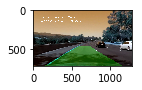

In [14]:
import scipy

images = get_images_by_dir('error')
imgs = images[1:]
left_line = Line()
right_line = Line()
cal_imgs = get_images_by_dir('camera_cal')
object_points,img_points = calibrate(cal_imgs,grid=(9,6))
M,Minv = get_M_Minv()
i = 1

for img in imgs:
    img = cv2.resize(img, (1280, 720))
    img_result = processing(img, object_points,img_points,M,Minv,left_line,right_line)
    plt.subplot(2, 3, i)
    plt.imshow(img_result, cmap='gray')
    string = 'output_images/output_error_%s.jpg'%i 
    scipy.misc.imsave(string, img_result)
    i = i + 1

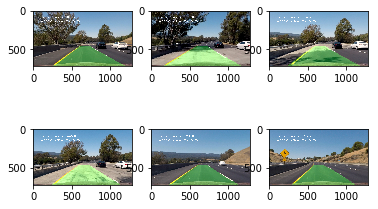

In [15]:
import scipy

images = get_images_by_dir('test_images')
imgs = images[1:]
left_line = Line()
right_line = Line()
cal_imgs = get_images_by_dir('camera_cal')
object_points,img_points = calibrate(cal_imgs,grid=(9,6))
M,Minv = get_M_Minv()
i = 1

for img in imgs:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_result = processing(img, object_points,img_points,M,Minv,left_line,right_line)
    plt.subplot(2, 3, i)
    plt.imshow(img_result, cmap='gray')
    string = 'output_images/output_%s.jpg'%i 
    scipy.misc.imsave(string, img_result)
    i = i + 1

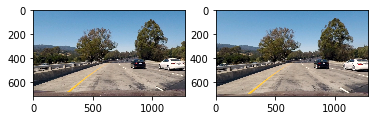

In [16]:
#output the image after cv2.undist
cal_imgs = get_images_by_dir('camera_cal')
object_points,img_points = calibrate(cal_imgs,grid=(9,6))

image = mpimg.imread('test_images/test1.jpg')
image_undistort = cal_undistort(image, object_points, img_points)
scipy.misc.imsave('output_images/test_1_undistort.jpg', image_undistort)

plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(image_undistort)

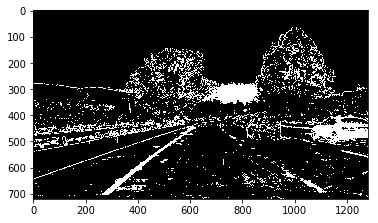

In [17]:
#output the binary_image
image_binary = thresholding(image_undistort)
scipy.misc.imsave('output_images/test_1_undistort_binary.jpg', image_binary)
plt.imshow(image_binary, cmap='gray')

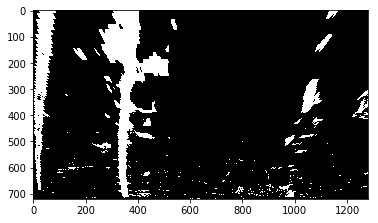

In [18]:
#output the image after perspective transform
image_perspective = cv2.warpPerspective(image_binary, M, image_binary.shape[1::-1])
scipy.misc.imsave('output_images/test_1_undistort_binary_perspective.jpg', image_perspective)
plt.imshow(image_perspective, cmap='gray')

In [19]:
from moviepy.editor import VideoFileClip

left_line = Line()
right_line = Line()
cal_imgs = get_images_by_dir('camera_cal')
object_points,img_points = calibrate(cal_imgs,grid=(9,6))
M,Minv = get_M_Minv()

project_outpath = 'vedio_out/project_video_out.mp4'
project_video_clip = VideoFileClip("project_video.mp4")
project_video_out_clip = project_video_clip.fl_image(lambda clip: processing(clip,object_points,img_points,M,Minv,left_line,right_line))
project_video_out_clip.write_videofile(project_outpath, audio=False)

[MoviePy] >>>> Building video vedio_out/project_video_out.mp4
[MoviePy] Writing video vedio_out/project_video_out.mp4


100%|█████████▉| 1260/1261 [08:23<00:00,  2.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vedio_out/project_video_out.mp4 



In [20]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_outpath))